In [ ]:
#@title Download Datasets 811

!gdown --fuzzy https://drive.google.com/file/d/1Z8RO6tidqQMdDZo8td-nNPBRc1SszGkA/view?usp=drive_link -O ds811_lettuce.zip

!unzip /content/ds811_lettuce.zip -d /content


Downloading...
From: https://drive.google.com/uc?id=1Z8RO6tidqQMdDZo8td-nNPBRc1SszGkA
To: /content/ds811_lettuce.zip
100% 5.81M/5.81M [00:00<00:00, 11.3MB/s]
Archive:  /content/ds811_lettuce.zip
   creating: /content/ds811_lettuce/
   creating: /content/ds811_lettuce/test/
   creating: /content/ds811_lettuce/test/Mildew/
  inflating: /content/ds811_lettuce/test/Mildew/lmild(87).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(71).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(57).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(13).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(2).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(21).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(40).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(53).jpg  
  inflating: /content/ds811_lettuce/test/Mildew/lmild(15).jpg  
   creating: /content/ds811_lettuce/test/MinNutrition/
  inflating: /content/ds811_lettuce/test/MinNut

In [ ]:
#@title Import Library

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random

# Augmentasi gambar
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Evaluasi confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from tensorflow.keras.models import load_model


In [ ]:
#@title Pengaturan Keras agar hasil dapat direproduksi kembali
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [ ]:
#@title Fungsi mengambil Path Data Direktori Train dan Testing

def get_path_ds(data_dir):
  train_dir = f'{data_dir}/train'
  test_dir = f'{data_dir}/test'

  return train_dir, test_dir


In [ ]:
#@title Fungsi Augmentasi Data

def augmentation_ds(val_split):
  aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=val_split
  )

  aug_val = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1.0 / 255,
      validation_split=val_split
  )

  rescale_test = rescale = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1.0 / 255
  )


  return aug_train, aug_val, rescale_test



In [ ]:
#@title Fungsi untuk Persiapan Datasets

def preparing_ds(function, bs, ts, cm = "sparse", trdir='', tsdir=''):

   aug_train, aug_val, rescale_test = function()

   train_ds = aug_train.flow_from_directory(
        trdir,
        target_size=ts,
        batch_size=bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="training"
    )

   val_ds = aug_val.flow_from_directory(
        trdir,
        target_size =ts,
        batch_size =bs,
        class_mode= cm,
        shuffle=True,
        seed=123,
        subset="validation"
    )

   test_ds = rescale_test.flow_from_directory(
        tsdir,
        batch_size = bs,
        target_size= ts,
        shuffle = False
    )

   classes = list(train_ds.class_indices.keys())

   n_classes = train_ds.num_classes

   return train_ds, val_ds, test_ds, classes, n_classes



In [ ]:
#@title Fungsi Menampilkan Grafik Pembelajaran, Confusion Matrix, & Heatmap Confusion Matrix

def learning_curve(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  fig = plt.figure(figsize=(15,10))
  grid = plt.GridSpec(2, 2, wspace=0.2, hspace = 0.3, figure =fig)

  plt.subplot(grid[0,0])
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.subplot(grid[0,1])
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation loss')
  plt.legend()

  # menampilkan grafik
  plt.show()

def evaluation_confusion_matrix(model, data):
  test_steps_per_epoch = np.math.ceil(data.samples / data.batch_size)
  predictions = model.predict(data, verbose=0)

  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = data.classes
  class_labels = list(data.class_indices.keys())
  cf_matrix = confusion_matrix(true_classes, predicted_classes)
  report_cf_matrix = classification_report(true_classes, predicted_classes, target_names=class_labels)

  return cf_matrix, report_cf_matrix

def cf_matrix_heatmap(cf_matrix, classes):
  plt.figure(figsize=(12,8))
  sns.set(font_scale=0.7)
  ax=sns.heatmap(cf_matrix, annot=True, cmap='Greens')

  # set x-axis label and title
  ax.set_xlabel("Prediksi", fontsize=10, labelpad=2)
  ax.xaxis.set_ticklabels(classes)

  # set y-axis label and title
  ax.set_ylabel("Aktual", fontsize=10, labelpad=2)
  ax.yaxis.set_ticklabels(classes)

  ax.set_title("Confusion Matrix Kualitas Selada", fontsize=12, pad=14)

  plt.show()


In [ ]:
#@title Ambil Path Data Train & Testing
train_dir_811, test_dir_811 = get_path_ds('/content/ds811_lettuce')

In [ ]:
#@title Memanggil Fungsi untuk Training Datasets dan Split Dataset 80% Train, 10% Validasi, 10% Testing
train_ds_811, val_ds_811, test_ds_811, classes_811, n_classes_811 = preparing_ds(
    lambda : augmentation_ds(0.1),
    bs = 8,
    ts = (256,256),
    cm= "sparse",
    trdir = train_dir_811,
    tsdir= test_dir_811
)

Found 292 images belonging to 4 classes.
Found 31 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [ ]:
#@title Fungsi Penentuan Step per Epoch & Validation Step

def get_step_per_epoch_and_val(train, val):
  step_per_epoch = np.math.floor(train.samples / train.batch_size)
  val_step = np.math.floor(val.samples / val.batch_size)

  return step_per_epoch, val_step


In [ ]:
#@title Penentuan Epoch, Step per Epoch & Validation Step
epochs_ = 50
input_shape = (256,256,3)

step_per_epoch_811, val_step_811 = get_step_per_epoch_and_val(train_ds_811, val_ds_811)

print(f'step_per_epoch : {step_per_epoch_811} \nval_step : {val_step_811}')


step_per_epoch : 36 
val_step : 3


### Membangun Model

#### Tunning Hyperparameter

*   Epoch 50
*   Dataset 80% Training, 10% Validation, 10% Testing
*   Step per epoch : Jumlah data train / batch size
*   Validation Step : Jumlah data validasi / batch size
*   Fungsi aktivasi Relu dan Outpout Softmax

*   Lapisan Konvolusi Pertama Sebanyak 32 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Dense Sebanyak 64 Node
*   Stride default (1,1) dan no zero padding

### Skenario 1
*   Tanpa Penambahan Dropout, learning rate default 0.001

### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.15, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.25
*   learning rate 0.001


### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.2, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.3
*   learning rate 0.0001

*   Optimizer Adam, RMSprop


## Model dengan Optimizer Adam, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

hist_1 = model_1.fit(
      train_ds,
      steps_per_epoch=step_per_epoch,
      epochs=epochs_,
      validation_data=val_ds,
      validation_steps=val_step,
      verbose=1,
      )


Epoch 1/50
36/36 [==============================] - 26s 216ms/step - loss: 1.2546 - accuracy: 0.4331 - val_loss: 1.3883 - val_accuracy: 0.4583
Epoch 2/50
36/36 [==============================] - 5s 143ms/step - loss: 1.0148 - accuracy: 0.5528 - val_loss: 0.9324 - val_accuracy: 0.3333
Epoch 3/50
36/36 [==============================] - 6s 176ms/step - loss: 0.9264 - accuracy: 0.5915 - val_loss: 0.7340 - val_accuracy: 0.6667
Epoch 4/50
36/36 [==============================] - 5s 145ms/step - loss: 0.7969 - accuracy: 0.7254 - val_loss: 1.0148 - val_accuracy: 0.5833
Epoch 5/50
36/36 [==============================] - 6s 173ms/step - loss: 0.8292 - accuracy: 0.6514 - val_loss: 0.5972 - val_accuracy: 0.7500
Epoch 6/50
36/36 [==============================] - 5s 147ms/step - loss: 0.8223 - accuracy: 0.6725 - val_loss: 0.6643 - val_accuracy: 0.6250
Epoch 7/50
36/36 [==============================] - 6s 158ms/step - loss: 0.6983 - accuracy: 0.7113 - val_loss: 0.4673 - val_accuracy: 0.7917
Epoch

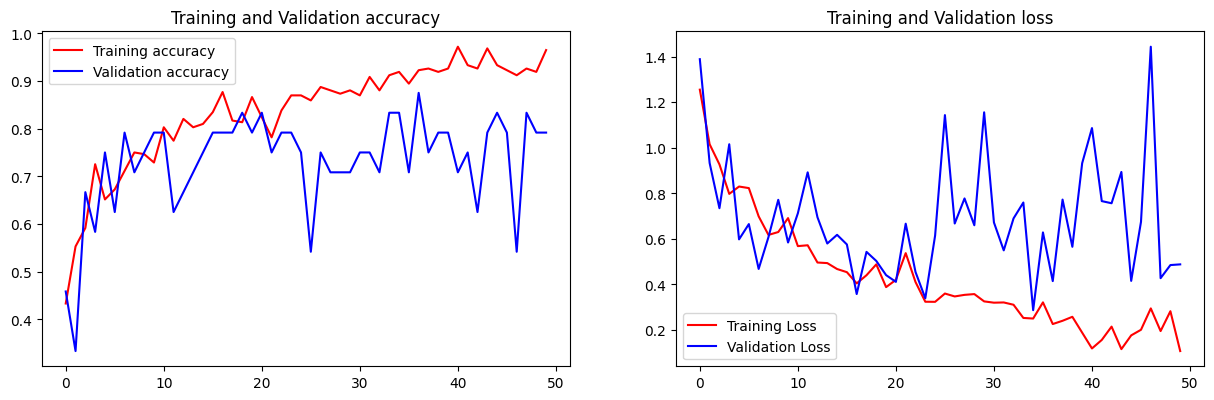

              precision    recall  f1-score   support

     Healthy       0.67      0.80      0.73        10
      Mildew       1.00      0.89      0.94         9
MinNutrition       0.67      0.60      0.63        10
         Rot       0.89      0.89      0.89         9

    accuracy                           0.79        38
   macro avg       0.81      0.79      0.80        38
weighted avg       0.80      0.79      0.79        38



In [ ]:
learning_curve(hist_1)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_1, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_2 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_2.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


# Pelatihan model
hist_2 = model_2.fit(
    train_ds,
    steps_per_epoch=step_per_epoch,
    epochs=epochs_,
    validation_data=val_ds,
    validation_steps=val_step,
    verbose=1,
    )

Epoch 1/50
36/36 [==============================] - 9s 171ms/step - loss: 1.5751 - accuracy: 0.2535 - val_loss: 1.3650 - val_accuracy: 0.2500
Epoch 2/50
36/36 [==============================] - 7s 192ms/step - loss: 1.1836 - accuracy: 0.4472 - val_loss: 1.0606 - val_accuracy: 0.4583
Epoch 3/50
36/36 [==============================] - 6s 170ms/step - loss: 0.9455 - accuracy: 0.5423 - val_loss: 0.7042 - val_accuracy: 0.6667
Epoch 4/50
36/36 [==============================] - 6s 166ms/step - loss: 0.9003 - accuracy: 0.5704 - val_loss: 0.9963 - val_accuracy: 0.4583
Epoch 5/50
36/36 [==============================] - 7s 190ms/step - loss: 0.9200 - accuracy: 0.5669 - val_loss: 0.8122 - val_accuracy: 0.5000
Epoch 6/50
36/36 [==============================] - 6s 166ms/step - loss: 0.7954 - accuracy: 0.6389 - val_loss: 0.6966 - val_accuracy: 0.6667
Epoch 7/50
36/36 [==============================] - 7s 190ms/step - loss: 0.7462 - accuracy: 0.6831 - val_loss: 0.6336 - val_accuracy: 0.7917
Epoch 

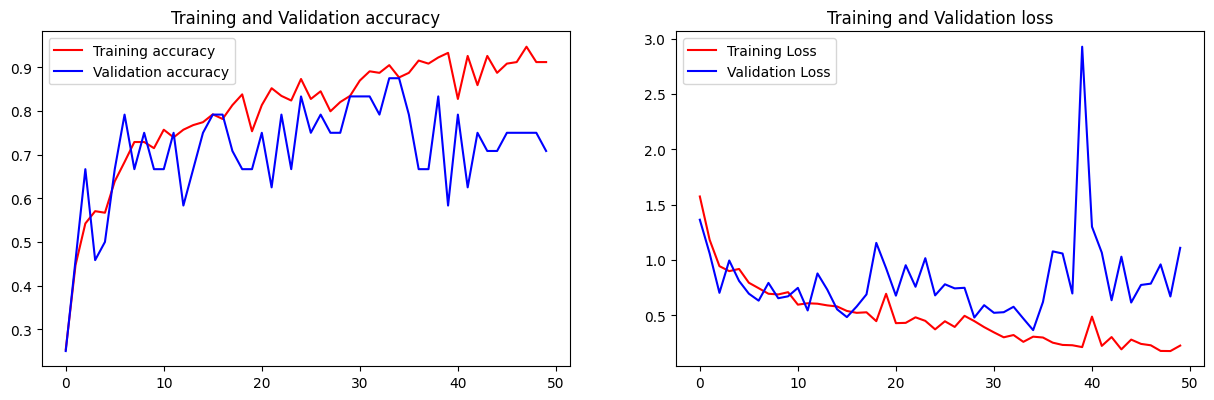

              precision    recall  f1-score   support

     Healthy       0.75      0.90      0.82        10
      Mildew       0.62      0.89      0.73         9
MinNutrition       0.83      0.50      0.62        10
         Rot       1.00      0.78      0.88         9

    accuracy                           0.76        38
   macro avg       0.80      0.77      0.76        38
weighted avg       0.80      0.76      0.76        38



In [ ]:
learning_curve(hist_2)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_2, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_811 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_811, activation='softmax')
])

model_811.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_811 = model_811.fit(
    train_ds_811,
    steps_per_epoch=step_per_epoch_811,
    epochs=epochs_,
    validation_data=val_ds_811,
    validation_steps=val_step_811,
    verbose=1,
    )

Epoch 1/50
36/36 [==============================] - 9s 170ms/step - loss: 1.4214 - accuracy: 0.2500 - val_loss: 1.3381 - val_accuracy: 0.5417
Epoch 2/50
36/36 [==============================] - 7s 185ms/step - loss: 1.2803 - accuracy: 0.4190 - val_loss: 1.1836 - val_accuracy: 0.5833
Epoch 3/50
36/36 [==============================] - 6s 166ms/step - loss: 1.1445 - accuracy: 0.4824 - val_loss: 1.0811 - val_accuracy: 0.4583
Epoch 4/50
36/36 [==============================] - 6s 163ms/step - loss: 1.0221 - accuracy: 0.5634 - val_loss: 1.0685 - val_accuracy: 0.4583
Epoch 5/50
36/36 [==============================] - 6s 164ms/step - loss: 0.9566 - accuracy: 0.5845 - val_loss: 0.9816 - val_accuracy: 0.4583
Epoch 6/50
36/36 [==============================] - 6s 167ms/step - loss: 0.8748 - accuracy: 0.6268 - val_loss: 0.9486 - val_accuracy: 0.5000
Epoch 7/50
36/36 [==============================] - 7s 194ms/step - loss: 0.8364 - accuracy: 0.6620 - val_loss: 0.8799 - val_accuracy: 0.5833
Epoch 

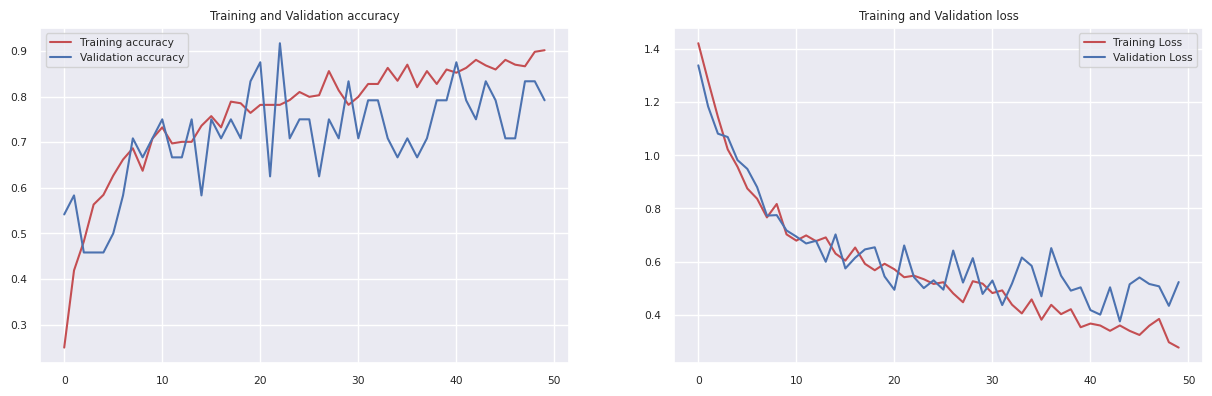

In [ ]:
#@title Hasil Kurva Pembelajaran
learning_curve(hist_811)

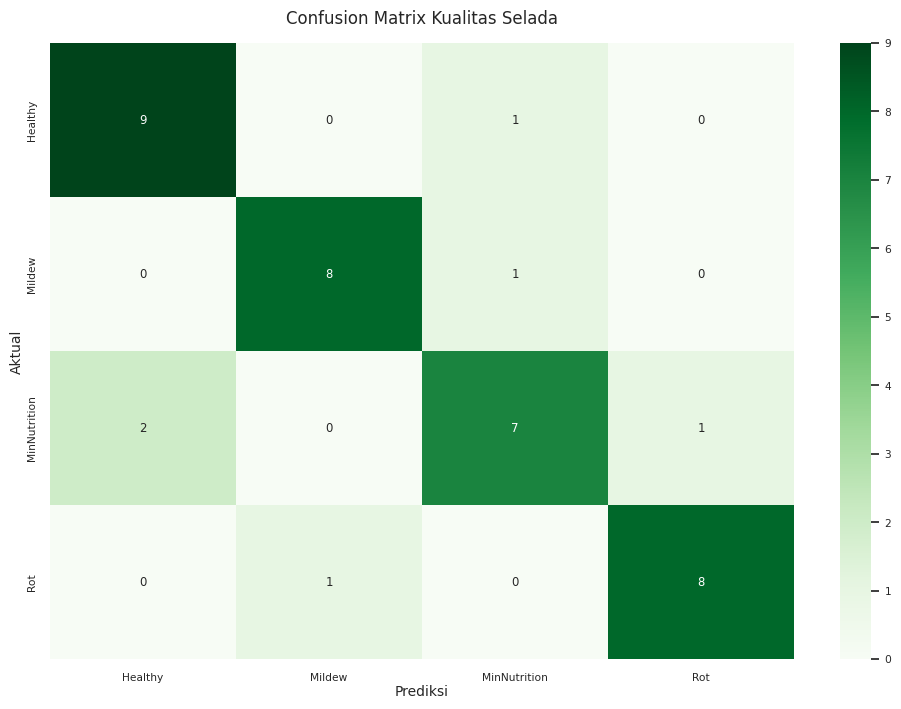

              precision    recall  f1-score   support

     Healthy       0.82      0.90      0.86        10
      Mildew       0.89      0.89      0.89         9
MinNutrition       0.78      0.70      0.74        10
         Rot       0.89      0.89      0.89         9

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_811, test_ds_811)

cf_matrix_heatmap(cf_matrix, classes_811)

print(report_cf_matrix)

## Model dengan Optimizer RMSprop, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.RMSprop(),
                metrics=['accuracy'])

hist_5 = model_5.fit(
      train_ds,
      steps_per_epoch=step_per_epoch,
      epochs=epochs_,
      validation_data=val_ds,
      validation_steps=val_step,
      verbose=1,
      )


Epoch 1/50
36/36 [==============================] - 8s 177ms/step - loss: 1.9617 - accuracy: 0.3486 - val_loss: 1.3112 - val_accuracy: 0.3750
Epoch 2/50
36/36 [==============================] - 5s 140ms/step - loss: 1.2046 - accuracy: 0.4472 - val_loss: 0.9482 - val_accuracy: 0.7083
Epoch 3/50
36/36 [==============================] - 6s 157ms/step - loss: 1.2104 - accuracy: 0.5317 - val_loss: 1.4438 - val_accuracy: 0.3750
Epoch 4/50
36/36 [==============================] - 6s 153ms/step - loss: 1.0070 - accuracy: 0.5669 - val_loss: 0.7491 - val_accuracy: 0.7083
Epoch 5/50
36/36 [==============================] - 5s 144ms/step - loss: 0.8941 - accuracy: 0.6127 - val_loss: 1.0101 - val_accuracy: 0.6667
Epoch 6/50
36/36 [==============================] - 5s 145ms/step - loss: 0.8694 - accuracy: 0.6761 - val_loss: 1.0380 - val_accuracy: 0.6250
Epoch 7/50
36/36 [==============================] - 5s 142ms/step - loss: 0.8012 - accuracy: 0.6690 - val_loss: 1.0873 - val_accuracy: 0.7083
Epoch 

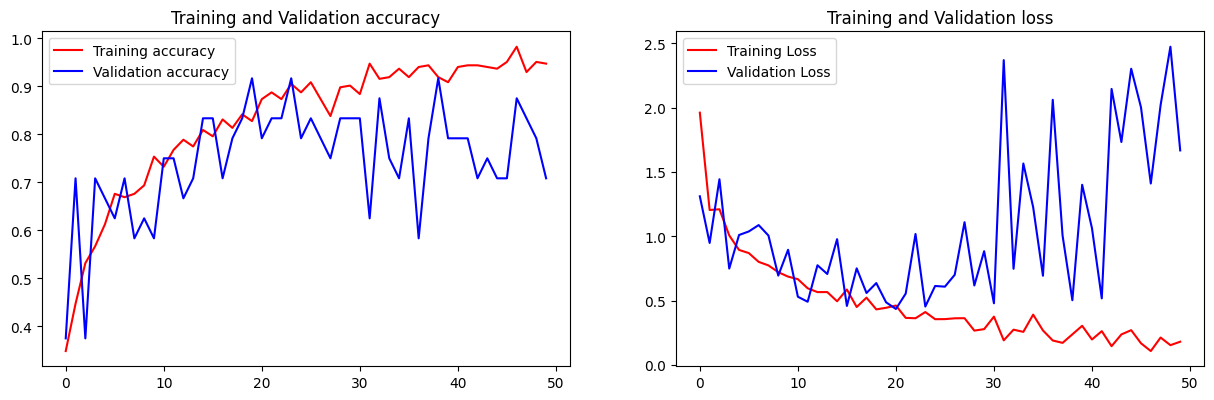

              precision    recall  f1-score   support

     Healthy       0.69      0.90      0.78        10
      Mildew       0.78      0.78      0.78         9
MinNutrition       0.80      0.40      0.53        10
         Rot       0.73      0.89      0.80         9

    accuracy                           0.74        38
   macro avg       0.75      0.74      0.72        38
weighted avg       0.75      0.74      0.72        38



In [ ]:
learning_curve(hist_5)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_5, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_6 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_6.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])


# Pelatihan model
hist_6 = model_6.fit(
    train_ds,
    steps_per_epoch=step_per_epoch,
    epochs=epochs_,
    validation_data=val_ds,
    validation_steps=val_step,
    verbose=1,
    )

Epoch 1/50
36/36 [==============================] - 9s 174ms/step - loss: 2.0897 - accuracy: 0.3592 - val_loss: 1.3380 - val_accuracy: 0.2500
Epoch 2/50
36/36 [==============================] - 7s 197ms/step - loss: 1.1955 - accuracy: 0.4366 - val_loss: 0.9607 - val_accuracy: 0.5000
Epoch 3/50
36/36 [==============================] - 6s 167ms/step - loss: 1.0135 - accuracy: 0.5599 - val_loss: 0.8604 - val_accuracy: 0.7917
Epoch 4/50
36/36 [==============================] - 7s 195ms/step - loss: 0.9952 - accuracy: 0.5493 - val_loss: 0.8153 - val_accuracy: 0.7917
Epoch 5/50
36/36 [==============================] - 6s 166ms/step - loss: 0.8909 - accuracy: 0.6444 - val_loss: 0.7136 - val_accuracy: 0.7917
Epoch 6/50
36/36 [==============================] - 7s 196ms/step - loss: 0.8073 - accuracy: 0.7007 - val_loss: 0.6676 - val_accuracy: 0.7500
Epoch 7/50
36/36 [==============================] - 6s 166ms/step - loss: 0.7574 - accuracy: 0.7113 - val_loss: 0.7388 - val_accuracy: 0.6250
Epoch 

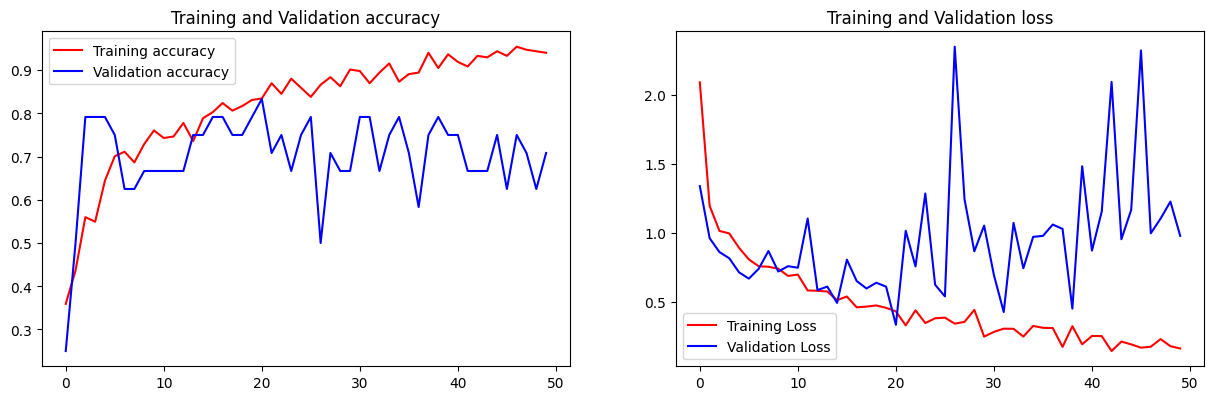

              precision    recall  f1-score   support

     Healthy       0.75      0.90      0.82        10
      Mildew       0.64      0.78      0.70         9
MinNutrition       0.67      0.40      0.50        10
         Rot       0.89      0.89      0.89         9

    accuracy                           0.74        38
   macro avg       0.74      0.74      0.73        38
weighted avg       0.73      0.74      0.72        38



In [ ]:
learning_curve(hist_6)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_6, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_811_rms = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_811, activation='softmax')
])

model_811_rms.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_811_rms = model_811_rms.fit(
    train_ds_811,
    steps_per_epoch=step_per_epoch_811,
    epochs=epochs_,
    validation_data=val_ds_811,
    validation_steps=val_step_811,
    verbose=1,
    )

Epoch 1/50
36/36 [==============================] - 8s 167ms/step - loss: 1.4076 - accuracy: 0.2887 - val_loss: 1.3449 - val_accuracy: 0.5833
Epoch 2/50
36/36 [==============================] - 6s 160ms/step - loss: 1.3022 - accuracy: 0.4261 - val_loss: 1.2550 - val_accuracy: 0.4583
Epoch 3/50
36/36 [==============================] - 7s 189ms/step - loss: 1.1701 - accuracy: 0.4824 - val_loss: 1.1486 - val_accuracy: 0.4167
Epoch 4/50
36/36 [==============================] - 6s 162ms/step - loss: 1.0766 - accuracy: 0.5211 - val_loss: 1.0413 - val_accuracy: 0.5417
Epoch 5/50
36/36 [==============================] - 7s 188ms/step - loss: 1.0446 - accuracy: 0.4930 - val_loss: 0.9914 - val_accuracy: 0.5000
Epoch 6/50
36/36 [==============================] - 6s 161ms/step - loss: 0.9524 - accuracy: 0.5739 - val_loss: 0.9545 - val_accuracy: 0.5000
Epoch 7/50
36/36 [==============================] - 7s 186ms/step - loss: 0.9242 - accuracy: 0.6127 - val_loss: 0.8618 - val_accuracy: 0.5833
Epoch 

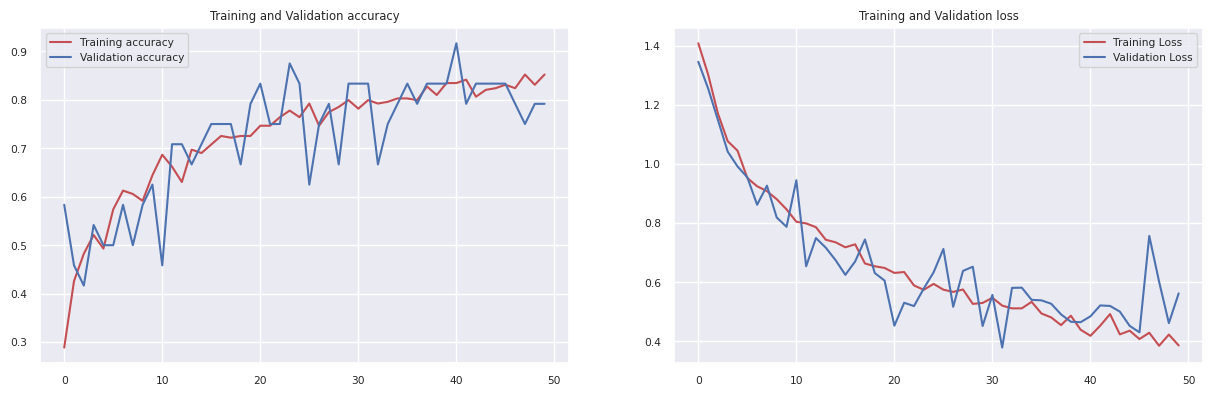

In [ ]:
learning_curve(hist_811_rms)

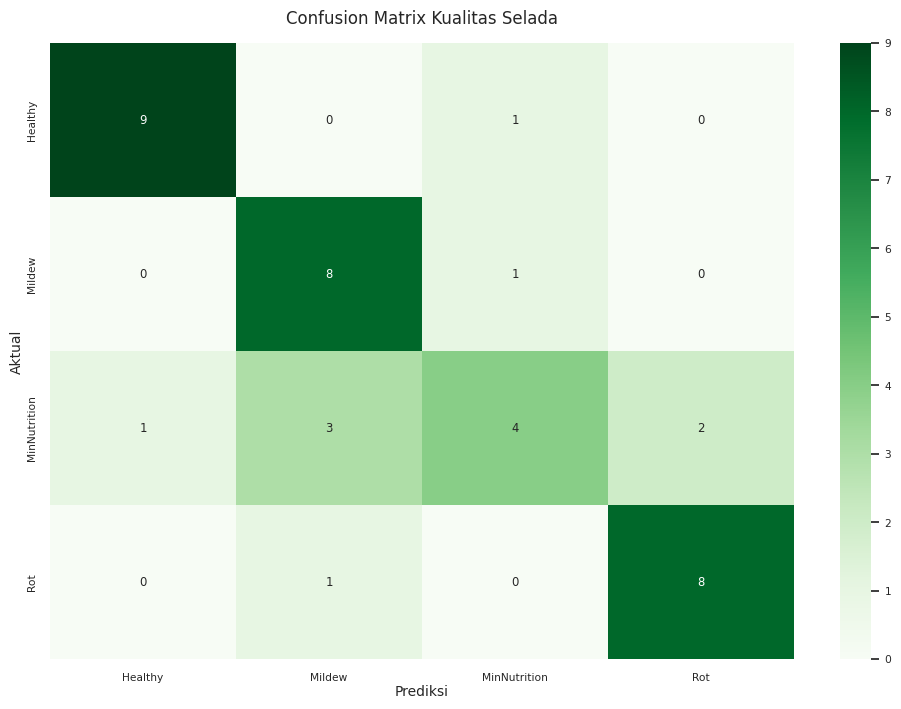

              precision    recall  f1-score   support

     Healthy       0.90      0.90      0.90        10
      Mildew       0.67      0.89      0.76         9
MinNutrition       0.67      0.40      0.50        10
         Rot       0.80      0.89      0.84         9

    accuracy                           0.76        38
   macro avg       0.76      0.77      0.75        38
weighted avg       0.76      0.76      0.75        38



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_811_rms, test_ds_811)

cf_matrix_heatmap(cf_matrix, classes_811)

print(report_cf_matrix)

In [ ]:
#@title Download Datasets 71515
!gdown --fuzzy https://drive.google.com/file/d/1RPNzUNVgVEk1x88x4UdcDhWP3dNXo018/view?usp=drive_link -O ds71515_lettuce.zip

!unzip /content/ds71515_lettuce.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1RPNzUNVgVEk1x88x4UdcDhWP3dNXo018
To: /content/ds71515_lettuce.zip
100% 5.81M/5.81M [00:00<00:00, 37.7MB/s]
Archive:  /content/ds71515_lettuce.zip
   creating: /content/ds71515_lettuce/
   creating: /content/ds71515_lettuce/test/
   creating: /content/ds71515_lettuce/test/Mildew/
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(48).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(9).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(28).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(87).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(71).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(57).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(13).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(2).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(74).jpg  
  inflating: /content/ds71515_lettuce/test/Mildew/lmild(21).jpg  
  inflati

In [ ]:
#@title Ambil Path Direktori Train dan Test
train_dir_71515, test_dir_71515 = get_path_ds('/content/ds71515_lettuce')

In [ ]:
#@title Persiapan Datasets Split Training & Validation
train_ds_71515, val_ds_71515, test_ds_71515, classes_71515, n_classes_71515 = preparing_ds(
    lambda : augmentation_ds(0.15),
    bs = 8,
    ts = (256,256),
    cm= "sparse",
    trdir = train_dir_71515,
    tsdir= test_dir_71515
)

Found 262 images belonging to 4 classes.
Found 43 images belonging to 4 classes.
Found 56 images belonging to 4 classes.


In [ ]:
#@title Penentuna Step per Epoch & Val step
step_per_epoch_71515, val_step_71515 = get_step_per_epoch_and_val(train_ds_71515, val_ds_71515)
print(f'step_per_epoch : {step_per_epoch_71515} \nval_step : {val_step_71515}')

step_per_epoch : 32 
val_step : 5


### Membangun Model

#### Tunning Hyperparameter

*   Epoch 50
*   Dataset 70% Training, 15% Validation, 15% Testing
*   Step per epoch : Jumlah data train / batch size
*   Validation Step : Jumlah data validasi / batch size
*   Fungsi aktivasi Relu dan Outpout Softmax

*   Lapisan Konvolusi Pertama Sebanyak 32 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Dense Sebanyak 64 Node
*   Stride default (1,1) dan no zero padding

### Skenario 1
*   Tanpa Penambahan Dropout, learning rate default 0.001

### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.15, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.25
*   learning rate 0.001


### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.2, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.3
*   learning rate 0.0001

*   Optimizer Adam, RMSprop

## Model dengan Optimizer Adam, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes_71515, activation='softmax')
])

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

hist_1 = model_1.fit(
      train_ds_71515,
      steps_per_epoch=step_per_epoch_71515,
      epochs=epochs_,
      validation_data=val_ds_71515,
      validation_steps=val_step_71515,
      verbose=1,
      )


Epoch 1/50
32/32 [==============================] - 19s 143ms/step - loss: 1.4004 - accuracy: 0.3150 - val_loss: 1.2318 - val_accuracy: 0.4750
Epoch 2/50
32/32 [==============================] - 4s 140ms/step - loss: 1.0977 - accuracy: 0.4764 - val_loss: 1.1454 - val_accuracy: 0.5250
Epoch 3/50
32/32 [==============================] - 5s 163ms/step - loss: 0.9727 - accuracy: 0.5354 - val_loss: 1.2605 - val_accuracy: 0.5250
Epoch 4/50
32/32 [==============================] - 4s 137ms/step - loss: 0.9433 - accuracy: 0.5512 - val_loss: 0.9908 - val_accuracy: 0.7000
Epoch 5/50
32/32 [==============================] - 5s 166ms/step - loss: 0.8948 - accuracy: 0.6181 - val_loss: 1.2786 - val_accuracy: 0.6000
Epoch 6/50
32/32 [==============================] - 5s 161ms/step - loss: 0.9809 - accuracy: 0.5512 - val_loss: 1.4021 - val_accuracy: 0.6250
Epoch 7/50
32/32 [==============================] - 4s 136ms/step - loss: 0.8479 - accuracy: 0.5787 - val_loss: 1.1517 - val_accuracy: 0.5750
Epoch

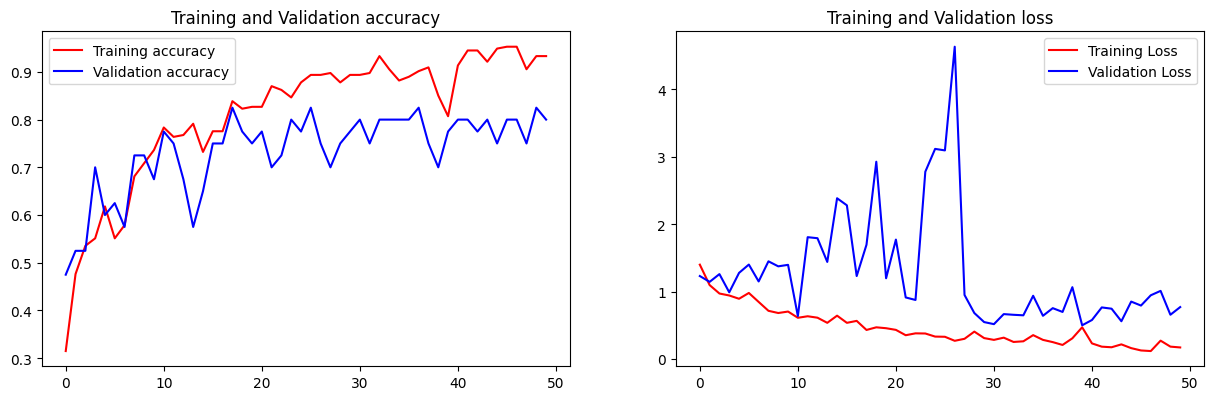

              precision    recall  f1-score   support

     Healthy       0.58      0.79      0.67        14
      Mildew       0.85      0.79      0.81        14
MinNutrition       0.58      0.50      0.54        14
         Rot       0.92      0.79      0.85        14

    accuracy                           0.71        56
   macro avg       0.73      0.71      0.72        56
weighted avg       0.73      0.71      0.72        56



In [ ]:
learning_curve(hist_1)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_1, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_2 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_71515, activation='softmax')
])

model_2.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


# Pelatihan model
hist_2 = model_2.fit(
    train_ds_71515,
    steps_per_epoch=step_per_epoch_71515,
    epochs=epochs_,
    validation_data=val_ds_71515,
    validation_steps=val_step_71515,
    verbose=1,
    )

Epoch 1/50
32/32 [==============================] - 8s 192ms/step - loss: 1.4446 - accuracy: 0.3858 - val_loss: 1.1247 - val_accuracy: 0.5000
Epoch 2/50
32/32 [==============================] - 6s 194ms/step - loss: 0.9878 - accuracy: 0.5512 - val_loss: 1.1574 - val_accuracy: 0.4250
Epoch 3/50
32/32 [==============================] - 5s 161ms/step - loss: 1.0025 - accuracy: 0.5000 - val_loss: 1.0296 - val_accuracy: 0.4750
Epoch 4/50
32/32 [==============================] - 6s 181ms/step - loss: 0.8717 - accuracy: 0.6181 - val_loss: 1.1015 - val_accuracy: 0.5500
Epoch 5/50
32/32 [==============================] - 6s 186ms/step - loss: 0.7965 - accuracy: 0.6417 - val_loss: 0.8213 - val_accuracy: 0.6500
Epoch 6/50
32/32 [==============================] - 6s 180ms/step - loss: 0.7199 - accuracy: 0.6953 - val_loss: 0.8543 - val_accuracy: 0.7250
Epoch 7/50
32/32 [==============================] - 5s 162ms/step - loss: 0.6813 - accuracy: 0.6969 - val_loss: 1.0285 - val_accuracy: 0.7500
Epoch 

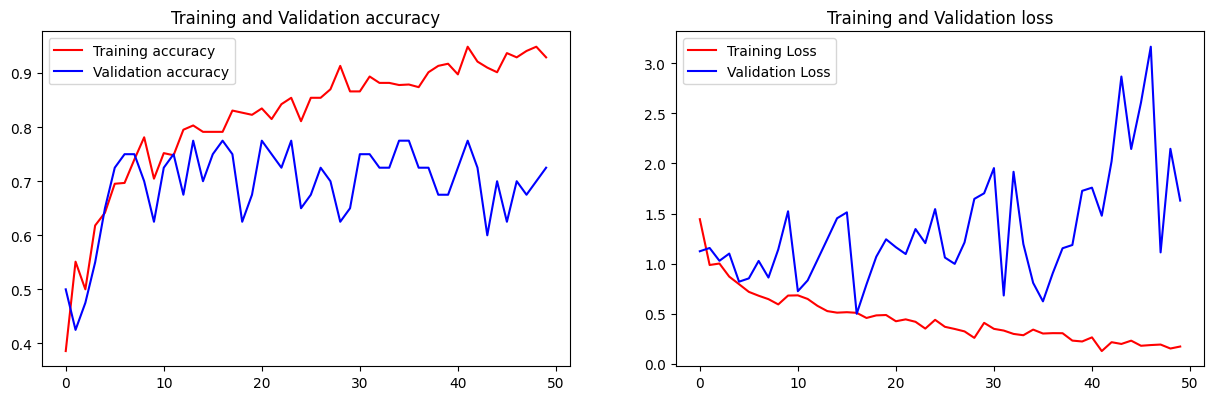

              precision    recall  f1-score   support

     Healthy       0.69      0.79      0.73        14
      Mildew       0.90      0.64      0.75        14
MinNutrition       0.71      0.71      0.71        14
         Rot       0.81      0.93      0.87        14

    accuracy                           0.77        56
   macro avg       0.78      0.77      0.77        56
weighted avg       0.78      0.77      0.77        56



In [ ]:
learning_curve(hist_2)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_2, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_71515 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_71515, activation='softmax')
])

model_71515.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_71515 = model_71515.fit(
    train_ds_71515,
    steps_per_epoch=step_per_epoch_71515,
    epochs=epochs_,
    validation_data=val_ds_71515,
    validation_steps=val_step_71515,
    verbose=1,
    )

Epoch 1/50
32/32 [==============================] - 9s 210ms/step - loss: 1.4135 - accuracy: 0.2677 - val_loss: 1.3553 - val_accuracy: 0.3500
Epoch 2/50
32/32 [==============================] - 6s 181ms/step - loss: 1.3109 - accuracy: 0.3819 - val_loss: 1.2619 - val_accuracy: 0.6000
Epoch 3/50
32/32 [==============================] - 6s 182ms/step - loss: 1.1701 - accuracy: 0.5000 - val_loss: 1.1055 - val_accuracy: 0.5500
Epoch 4/50
32/32 [==============================] - 6s 198ms/step - loss: 1.0238 - accuracy: 0.5945 - val_loss: 1.0029 - val_accuracy: 0.5250
Epoch 5/50
32/32 [==============================] - 5s 167ms/step - loss: 0.8909 - accuracy: 0.6535 - val_loss: 0.8176 - val_accuracy: 0.6250
Epoch 6/50
32/32 [==============================] - 6s 199ms/step - loss: 0.8159 - accuracy: 0.6654 - val_loss: 0.8374 - val_accuracy: 0.6000
Epoch 7/50
32/32 [==============================] - 5s 169ms/step - loss: 0.7886 - accuracy: 0.6850 - val_loss: 0.8333 - val_accuracy: 0.6250
Epoch 

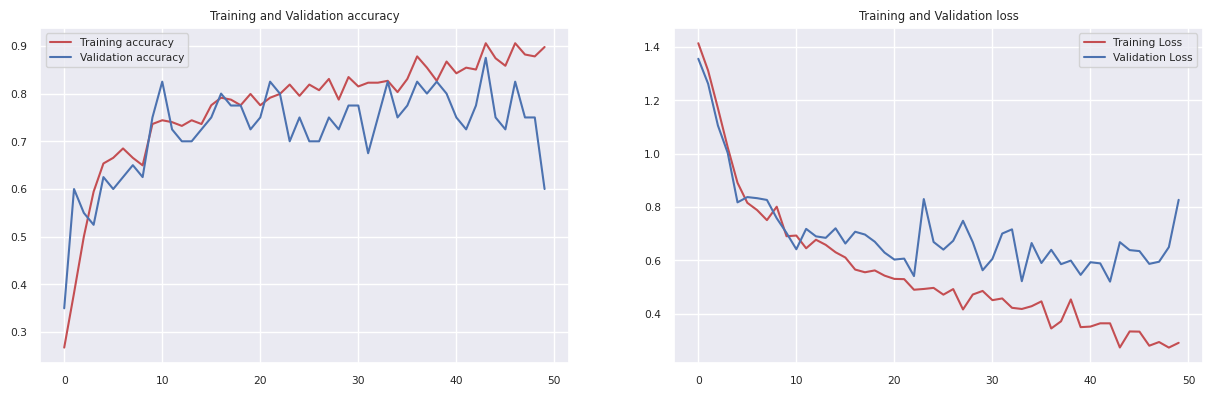

In [ ]:
#@title Hasil Kurva Pembelajaran
learning_curve(hist_71515)

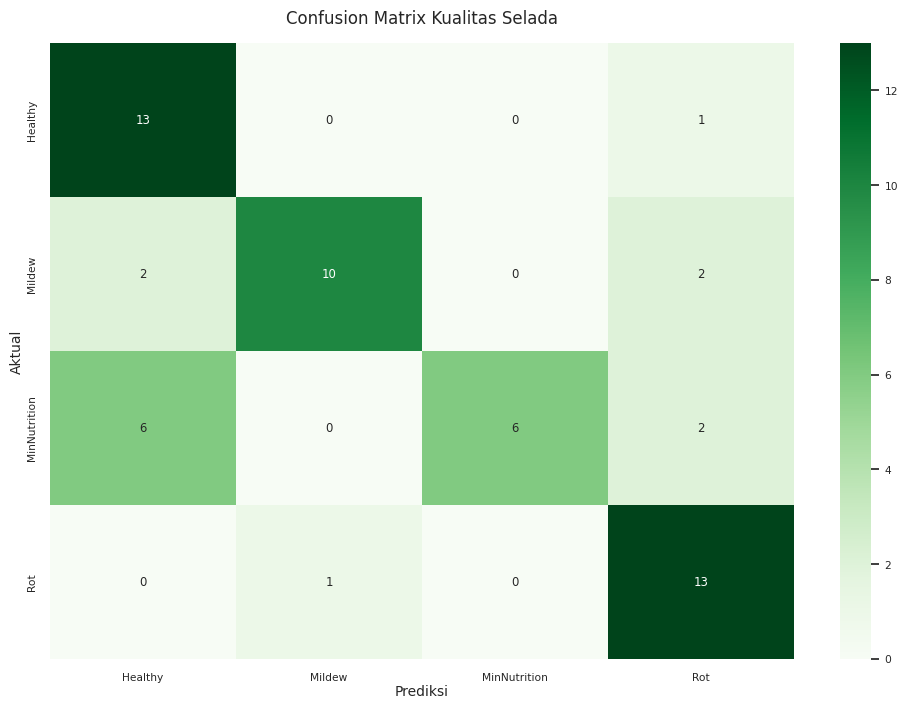

              precision    recall  f1-score   support

     Healthy       0.62      0.93      0.74        14
      Mildew       0.91      0.71      0.80        14
MinNutrition       1.00      0.43      0.60        14
         Rot       0.72      0.93      0.81        14

    accuracy                           0.75        56
   macro avg       0.81      0.75      0.74        56
weighted avg       0.81      0.75      0.74        56



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_71515, test_ds_71515)

cf_matrix_heatmap(cf_matrix, classes_71515)

print(report_cf_matrix)

## Model dengan Optimizer RMSprop, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes_71515, activation='softmax')
])

model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.RMSprop(),
                metrics=['accuracy'])

hist_5 = model_5.fit(
      train_ds_71515,
      steps_per_epoch=step_per_epoch_71515,
      epochs=epochs_,
      validation_data=val_ds_71515,
      validation_steps=val_step_71515,
      verbose=1,
      )


Epoch 1/50
32/32 [==============================] - 7s 142ms/step - loss: 1.7467 - accuracy: 0.2402 - val_loss: 1.3388 - val_accuracy: 0.3000
Epoch 2/50
32/32 [==============================] - 5s 166ms/step - loss: 1.3339 - accuracy: 0.3346 - val_loss: 1.2537 - val_accuracy: 0.3500
Epoch 3/50
32/32 [==============================] - 4s 137ms/step - loss: 1.1913 - accuracy: 0.4606 - val_loss: 1.3692 - val_accuracy: 0.3750
Epoch 4/50
32/32 [==============================] - 5s 160ms/step - loss: 1.0380 - accuracy: 0.5157 - val_loss: 1.1188 - val_accuracy: 0.5000
Epoch 5/50
32/32 [==============================] - 5s 141ms/step - loss: 0.9811 - accuracy: 0.5748 - val_loss: 0.9841 - val_accuracy: 0.7250
Epoch 6/50
32/32 [==============================] - 4s 136ms/step - loss: 0.8763 - accuracy: 0.6181 - val_loss: 1.0671 - val_accuracy: 0.6750
Epoch 7/50
32/32 [==============================] - 5s 166ms/step - loss: 0.8168 - accuracy: 0.6575 - val_loss: 1.0730 - val_accuracy: 0.6500
Epoch 

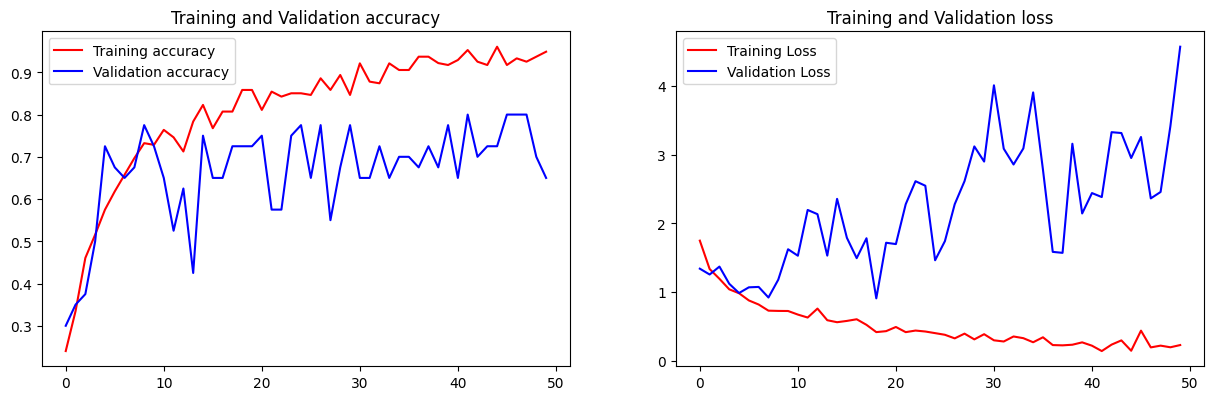

              precision    recall  f1-score   support

     Healthy       0.67      0.86      0.75        14
      Mildew       1.00      0.57      0.73        14
MinNutrition       0.60      0.64      0.62        14
         Rot       0.73      0.79      0.76        14

    accuracy                           0.71        56
   macro avg       0.75      0.71      0.71        56
weighted avg       0.75      0.71      0.71        56



In [ ]:
learning_curve(hist_5)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_5, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_6 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_71515, activation='softmax')
])

model_6.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])


# Pelatihan model
hist_6 = model_6.fit(
    train_ds_71515,
    steps_per_epoch=step_per_epoch_71515,
    epochs=epochs_,
    validation_data=val_ds_71515,
    validation_steps=val_step_71515,
    verbose=1,
    )

Epoch 1/50
32/32 [==============================] - 8s 189ms/step - loss: 1.7536 - accuracy: 0.3858 - val_loss: 1.1484 - val_accuracy: 0.5250
Epoch 2/50
32/32 [==============================] - 5s 159ms/step - loss: 1.1081 - accuracy: 0.4764 - val_loss: 1.0173 - val_accuracy: 0.5250
Epoch 3/50
32/32 [==============================] - 5s 159ms/step - loss: 1.0885 - accuracy: 0.5315 - val_loss: 1.1266 - val_accuracy: 0.4000
Epoch 4/50
32/32 [==============================] - 6s 187ms/step - loss: 0.9879 - accuracy: 0.6457 - val_loss: 0.9157 - val_accuracy: 0.6750
Epoch 5/50
32/32 [==============================] - 5s 161ms/step - loss: 0.9349 - accuracy: 0.6496 - val_loss: 0.8711 - val_accuracy: 0.6750
Epoch 6/50
32/32 [==============================] - 6s 186ms/step - loss: 0.8299 - accuracy: 0.6654 - val_loss: 0.8197 - val_accuracy: 0.7000
Epoch 7/50
32/32 [==============================] - 5s 170ms/step - loss: 0.8426 - accuracy: 0.6417 - val_loss: 0.8252 - val_accuracy: 0.7000
Epoch 

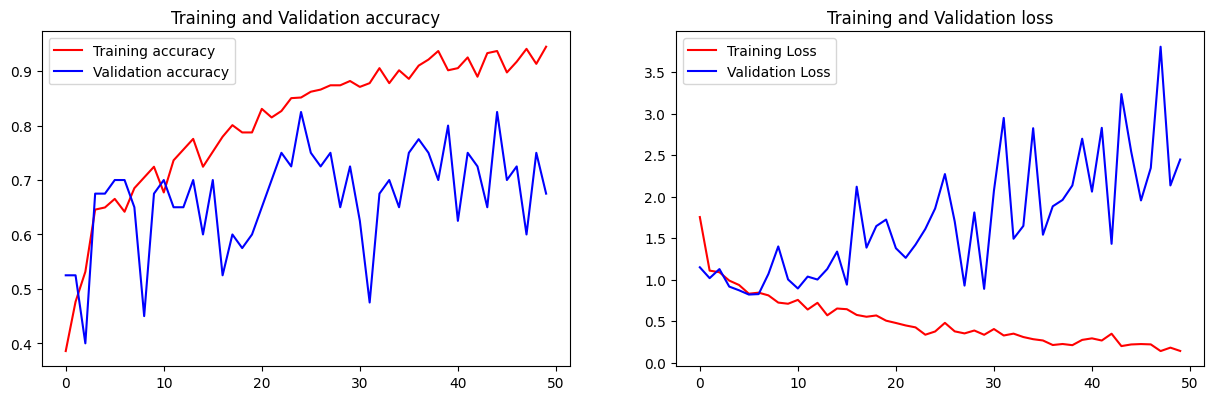

              precision    recall  f1-score   support

     Healthy       0.69      0.79      0.73        14
      Mildew       0.77      0.71      0.74        14
MinNutrition       0.60      0.43      0.50        14
         Rot       0.71      0.86      0.77        14

    accuracy                           0.70        56
   macro avg       0.69      0.70      0.69        56
weighted avg       0.69      0.70      0.69        56



In [ ]:
learning_curve(hist_6)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_6, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_71515_rms = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_71515, activation='softmax')
])

model_71515_rms.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_71515_rms = model_71515_rms.fit(
    train_ds_71515,
    steps_per_epoch=step_per_epoch_71515,
    epochs=epochs_,
    validation_data=val_ds_71515,
    validation_steps=val_step_71515,
    verbose=1,
    )

Epoch 1/50
32/32 [==============================] - 7s 173ms/step - loss: 1.4254 - accuracy: 0.2422 - val_loss: 1.3736 - val_accuracy: 0.2750
Epoch 2/50
32/32 [==============================] - 5s 169ms/step - loss: 1.3186 - accuracy: 0.3543 - val_loss: 1.3148 - val_accuracy: 0.4000
Epoch 3/50
32/32 [==============================] - 6s 184ms/step - loss: 1.2552 - accuracy: 0.4331 - val_loss: 1.2583 - val_accuracy: 0.3750
Epoch 4/50
32/32 [==============================] - 6s 176ms/step - loss: 1.1331 - accuracy: 0.4606 - val_loss: 1.1972 - val_accuracy: 0.3500
Epoch 5/50
32/32 [==============================] - 6s 197ms/step - loss: 1.0841 - accuracy: 0.5472 - val_loss: 1.1293 - val_accuracy: 0.4500
Epoch 6/50
32/32 [==============================] - 6s 201ms/step - loss: 1.0293 - accuracy: 0.5433 - val_loss: 1.1121 - val_accuracy: 0.4750
Epoch 7/50
32/32 [==============================] - 5s 164ms/step - loss: 0.9774 - accuracy: 0.5591 - val_loss: 1.0196 - val_accuracy: 0.5750
Epoch 

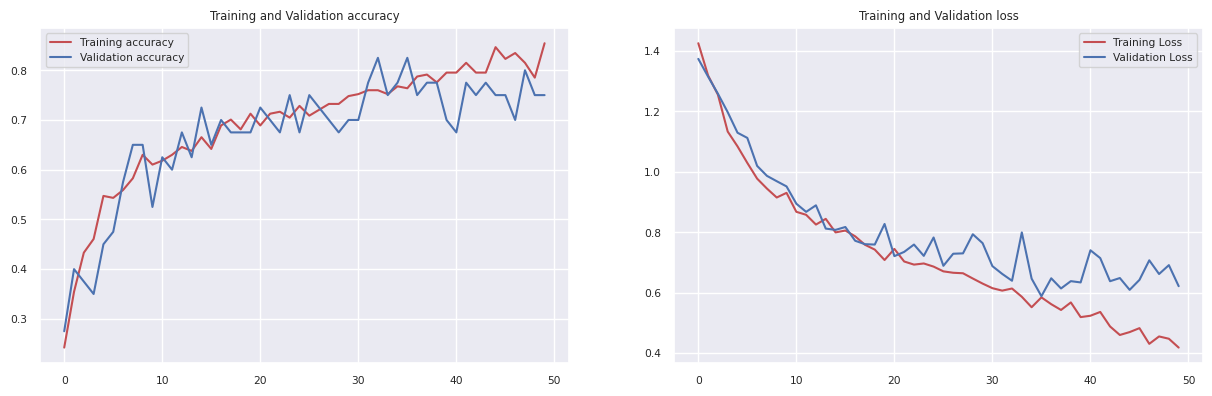

In [ ]:
#@title Hasil Kurva Pembelajaran
learning_curve(hist_71515_rms)

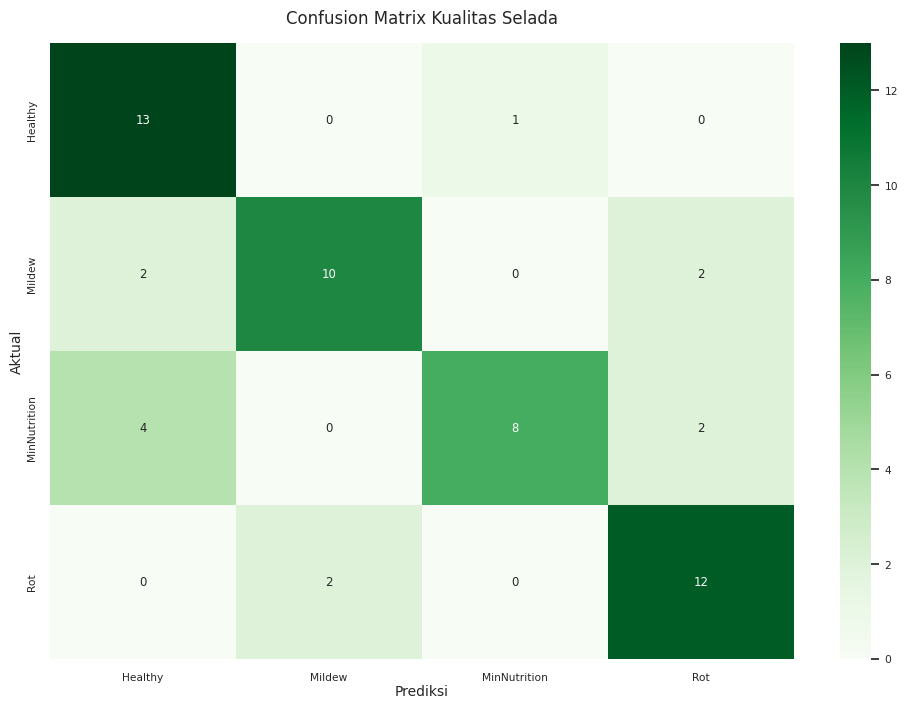

              precision    recall  f1-score   support

     Healthy       0.68      0.93      0.79        14
      Mildew       0.83      0.71      0.77        14
MinNutrition       0.89      0.57      0.70        14
         Rot       0.75      0.86      0.80        14

    accuracy                           0.77        56
   macro avg       0.79      0.77      0.76        56
weighted avg       0.79      0.77      0.76        56



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_71515_rms, test_ds_71515)

cf_matrix_heatmap(cf_matrix, classes_71515)

print(report_cf_matrix)

In [ ]:
#@title Download Datasets 622
!gdown --fuzzy https://drive.google.com/file/d/1i27DpzXUJZqGkLcSvQd9JuBSZWIGDrvd/view?usp=drive_link -O ds622_lettuce.zip

!unzip /content/ds622_lettuce.zip -d /content

In [ ]:
#@title Ambil Path Direktori Train dan Test
train_dir_622, test_dir_622 = get_path_ds('/content/ds622_lettuce')

In [ ]:
#@title Persiapan Datasets Split Training & Validation
train_ds_622, val_ds_622, test_ds_622, classes_622, n_classes_622 = preparing_ds(
    lambda : augmentation_ds(0.2),
    bs = 8,
    ts = (256,256),
    cm= "sparse",
    trdir = train_dir_622,
    tsdir= test_dir_622
)

Found 232 images belonging to 4 classes.
Found 55 images belonging to 4 classes.
Found 74 images belonging to 4 classes.


In [ ]:
#@title Penentuna Step per Epoch & Val step
step_per_epoch_622, val_step_622 = get_step_per_epoch_and_val(train_ds_622, val_ds_622)
print(f'step_per_epoch : {step_per_epoch_622} \nval_step : {val_step_622}')

step_per_epoch : 29 
val_step : 6


### Membangun Model

#### Tunning Hyperparameter

*   Epoch 50
*   Dataset 60% Training, 20% Validation, 20% Testing
*   Step per epoch : Jumlah data train / batch size
*   Validation Step : Jumlah data validasi / batch size
*   Fungsi aktivasi Relu dan Outpout Softmax

*   Lapisan Konvolusi Pertama Sebanyak 32 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Konvolusi Kedua Sebanyak 64 Filter dengan Ukuran 3x3
*   Lapisan Maxpooling Pertama Berukuran 2x2
*   Lapisan Dense Sebanyak 64 Node
*   Stride default (1,1) dan no zero padding

### Skenario 1
*   Tanpa Penambahan Dropout, learning rate default 0.001

### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.15, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.25
*   learning rate 0.001


### Skenario 2
*   Penambahan Droupout setelah konvolusi Kedua 0.2, dan Ketiga 0.2
*   Penambahan Droupout setelah Dense 0.3
*   learning rate 0.0001

*   Optimizer Adam, RMSprop


## Model dengan Optimizer Adam, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes_622, activation='softmax')
])

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

hist_1 = model_1.fit(
      train_ds_622,
      steps_per_epoch=step_per_epoch_622,
      epochs=epochs_,
      validation_data=val_ds_622,
      validation_steps=val_step_622,
      verbose=1,
      )


Epoch 1/50
29/29 [==============================] - 22s 208ms/step - loss: 1.4569 - accuracy: 0.3362 - val_loss: 1.2307 - val_accuracy: 0.3125
Epoch 2/50
29/29 [==============================] - 5s 157ms/step - loss: 1.1911 - accuracy: 0.3922 - val_loss: 1.1158 - val_accuracy: 0.4375
Epoch 3/50
29/29 [==============================] - 6s 194ms/step - loss: 1.1020 - accuracy: 0.4828 - val_loss: 1.2151 - val_accuracy: 0.5208
Epoch 4/50
29/29 [==============================] - 5s 156ms/step - loss: 1.0148 - accuracy: 0.5086 - val_loss: 0.9125 - val_accuracy: 0.5833
Epoch 5/50
29/29 [==============================] - 6s 199ms/step - loss: 0.8662 - accuracy: 0.5560 - val_loss: 0.9022 - val_accuracy: 0.7292
Epoch 6/50
29/29 [==============================] - 5s 185ms/step - loss: 0.8674 - accuracy: 0.6250 - val_loss: 1.2053 - val_accuracy: 0.5833
Epoch 7/50
29/29 [==============================] - 6s 194ms/step - loss: 0.8221 - accuracy: 0.6121 - val_loss: 1.1247 - val_accuracy: 0.6458
Epoch

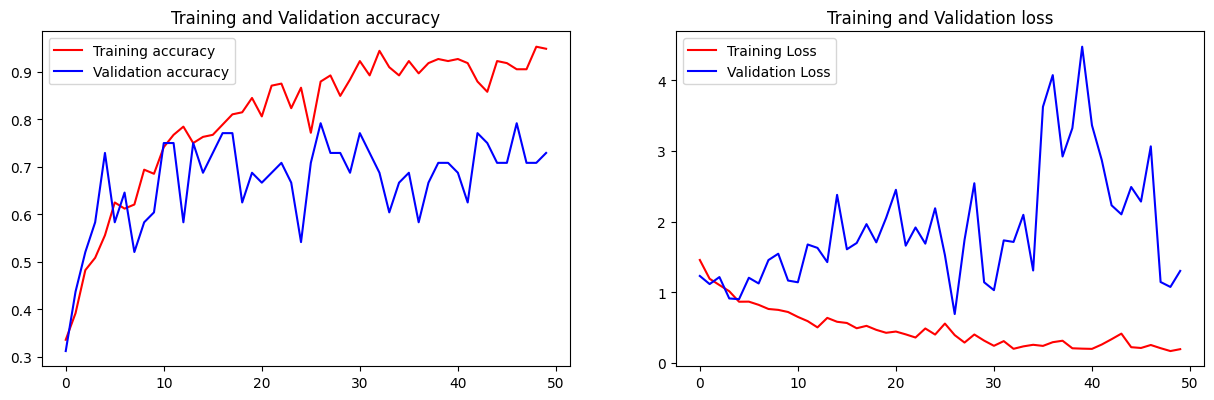

              precision    recall  f1-score   support

     Healthy       0.65      0.89      0.76        19
      Mildew       0.80      0.67      0.73        18
MinNutrition       0.67      0.53      0.59        19
         Rot       0.83      0.83      0.83        18

    accuracy                           0.73        74
   macro avg       0.74      0.73      0.73        74
weighted avg       0.74      0.73      0.72        74



In [ ]:
learning_curve(hist_1)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_1, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_2 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_622, activation='softmax')
])

model_2.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


# Pelatihan model
hist_2 = model_2.fit(
    train_ds_622,
    steps_per_epoch=step_per_epoch_622,
    epochs=epochs_,
    validation_data=val_ds_622,
    validation_steps=val_step_622,
    verbose=1,
    )

Epoch 1/50
29/29 [==============================] - 9s 225ms/step - loss: 1.5287 - accuracy: 0.2931 - val_loss: 1.3119 - val_accuracy: 0.4375
Epoch 2/50
29/29 [==============================] - 5s 182ms/step - loss: 1.1791 - accuracy: 0.4224 - val_loss: 1.1461 - val_accuracy: 0.3958
Epoch 3/50
29/29 [==============================] - 7s 258ms/step - loss: 1.0823 - accuracy: 0.4784 - val_loss: 0.9858 - val_accuracy: 0.6250
Epoch 4/50
29/29 [==============================] - 6s 190ms/step - loss: 0.8864 - accuracy: 0.6164 - val_loss: 0.7801 - val_accuracy: 0.6458
Epoch 5/50
29/29 [==============================] - 5s 178ms/step - loss: 0.8000 - accuracy: 0.6466 - val_loss: 0.7853 - val_accuracy: 0.7292
Epoch 6/50
29/29 [==============================] - 5s 177ms/step - loss: 0.7516 - accuracy: 0.6724 - val_loss: 1.0532 - val_accuracy: 0.5208
Epoch 7/50
29/29 [==============================] - 5s 183ms/step - loss: 0.7611 - accuracy: 0.6638 - val_loss: 0.9853 - val_accuracy: 0.7083
Epoch 

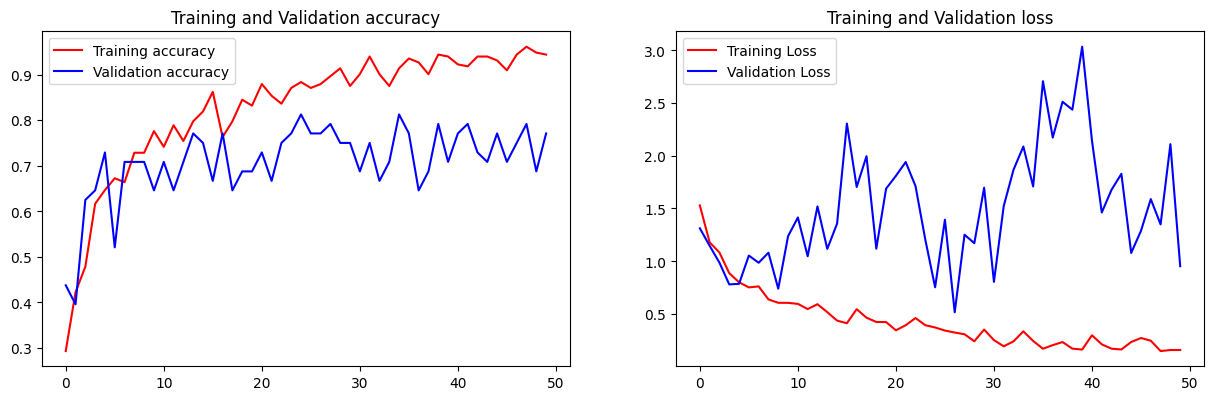

              precision    recall  f1-score   support

     Healthy       0.81      0.89      0.85        19
      Mildew       0.86      0.67      0.75        18
MinNutrition       0.78      0.74      0.76        19
         Rot       0.76      0.89      0.82        18

    accuracy                           0.80        74
   macro avg       0.80      0.80      0.79        74
weighted avg       0.80      0.80      0.79        74



In [ ]:
learning_curve(hist_2)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_2, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_622 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_622, activation='softmax')
])

model_622.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_622 = model_622.fit(
    train_ds_622,
    steps_per_epoch=step_per_epoch_622,
    epochs=epochs_,
    validation_data=val_ds_622,
    validation_steps=val_step_622,
    verbose=1,
    )

Epoch 1/50
29/29 [==============================] - 8s 211ms/step - loss: 1.4036 - accuracy: 0.2845 - val_loss: 1.3439 - val_accuracy: 0.2500
Epoch 2/50
29/29 [==============================] - 5s 168ms/step - loss: 1.2461 - accuracy: 0.4052 - val_loss: 1.1462 - val_accuracy: 0.5000
Epoch 3/50
29/29 [==============================] - 6s 205ms/step - loss: 1.0727 - accuracy: 0.4871 - val_loss: 1.1455 - val_accuracy: 0.5417
Epoch 4/50
29/29 [==============================] - 5s 171ms/step - loss: 0.9744 - accuracy: 0.5560 - val_loss: 1.0446 - val_accuracy: 0.4583
Epoch 5/50
29/29 [==============================] - 6s 199ms/step - loss: 0.9484 - accuracy: 0.5819 - val_loss: 0.9579 - val_accuracy: 0.6042
Epoch 6/50
29/29 [==============================] - 5s 167ms/step - loss: 0.8947 - accuracy: 0.6336 - val_loss: 0.9026 - val_accuracy: 0.5417
Epoch 7/50
29/29 [==============================] - 6s 201ms/step - loss: 0.8241 - accuracy: 0.6078 - val_loss: 0.8561 - val_accuracy: 0.6458
Epoch 

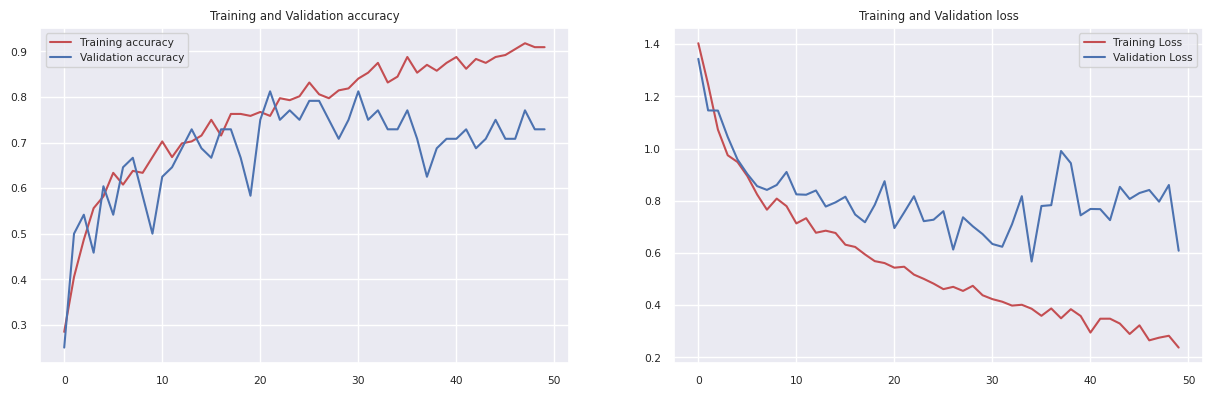

In [ ]:
#@title Hasil Kurva Pembelajaran
learning_curve(hist_622)

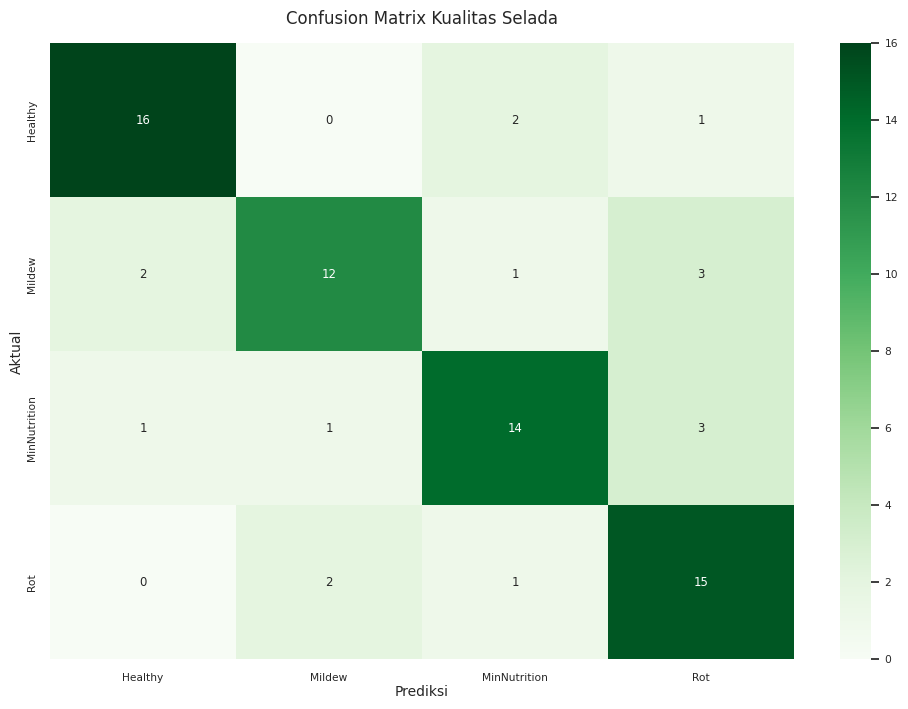

              precision    recall  f1-score   support

     Healthy       0.84      0.84      0.84        19
      Mildew       0.80      0.67      0.73        18
MinNutrition       0.78      0.74      0.76        19
         Rot       0.68      0.83      0.75        18

    accuracy                           0.77        74
   macro avg       0.78      0.77      0.77        74
weighted avg       0.78      0.77      0.77        74



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_622, test_ds_622)

cf_matrix_heatmap(cf_matrix, classes_622)

print(report_cf_matrix)

## Model dengan Optimizer RMSprop, 50 epochs Skenario 1,2, & 3

In [ ]:
#@title Skenario 1
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes_622, activation='softmax')
])

model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.RMSprop(),
                metrics=['accuracy'])

hist_5 = model_5.fit(
      train_ds_622,
      steps_per_epoch=step_per_epoch_622,
      epochs=epochs_,
      validation_data=val_ds_622,
      validation_steps=val_step_622,
      verbose=1,
      )


Epoch 1/50
29/29 [==============================] - 8s 218ms/step - loss: 1.5616 - accuracy: 0.3448 - val_loss: 1.6508 - val_accuracy: 0.2708
Epoch 2/50
29/29 [==============================] - 5s 172ms/step - loss: 1.2037 - accuracy: 0.4569 - val_loss: 1.2017 - val_accuracy: 0.5208
Epoch 3/50
29/29 [==============================] - 4s 153ms/step - loss: 1.0314 - accuracy: 0.5431 - val_loss: 1.2156 - val_accuracy: 0.4167
Epoch 4/50
29/29 [==============================] - 6s 195ms/step - loss: 1.0462 - accuracy: 0.6034 - val_loss: 1.5915 - val_accuracy: 0.5208
Epoch 5/50
29/29 [==============================] - 4s 154ms/step - loss: 0.8163 - accuracy: 0.6379 - val_loss: 1.2834 - val_accuracy: 0.6250
Epoch 6/50
29/29 [==============================] - 4s 155ms/step - loss: 0.8259 - accuracy: 0.6897 - val_loss: 1.5654 - val_accuracy: 0.5000
Epoch 7/50
29/29 [==============================] - 6s 191ms/step - loss: 0.7268 - accuracy: 0.6940 - val_loss: 1.4365 - val_accuracy: 0.6875
Epoch 

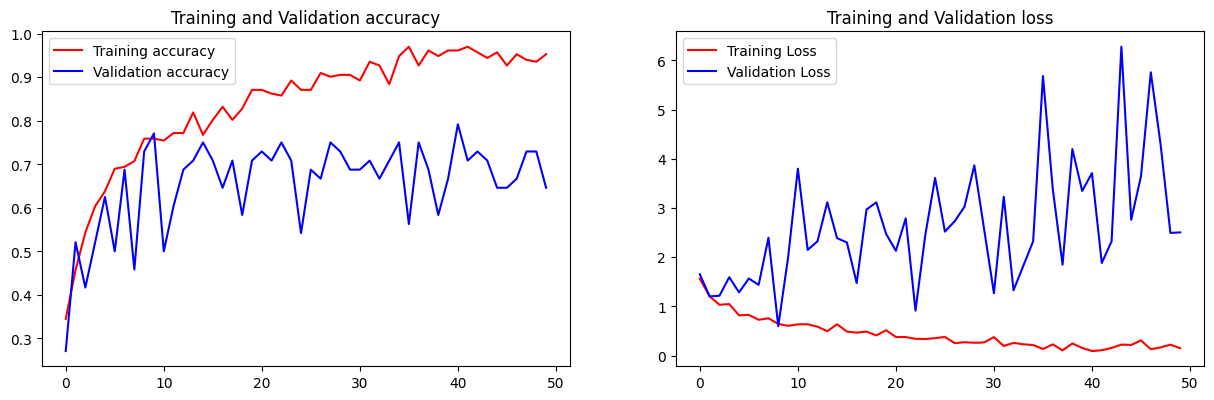

              precision    recall  f1-score   support

     Healthy       0.80      0.84      0.82        19
      Mildew       0.80      0.67      0.73        18
MinNutrition       0.76      0.68      0.72        19
         Rot       0.77      0.94      0.85        18

    accuracy                           0.78        74
   macro avg       0.78      0.78      0.78        74
weighted avg       0.78      0.78      0.78        74



In [ ]:
learning_curve(hist_5)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_5, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 2
model_6 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_622, activation='softmax')
])

model_6.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])


# Pelatihan model
hist_6 = model_6.fit(
    train_ds_622,
    steps_per_epoch=step_per_epoch_622,
    epochs=epochs_,
    validation_data=val_ds_622,
    validation_steps=val_step_622,
    verbose=1,
    )

Epoch 1/50
29/29 [==============================] - 8s 211ms/step - loss: 2.6907 - accuracy: 0.3190 - val_loss: 1.2627 - val_accuracy: 0.4375
Epoch 2/50
29/29 [==============================] - 5s 182ms/step - loss: 1.2281 - accuracy: 0.3966 - val_loss: 1.0652 - val_accuracy: 0.5625
Epoch 3/50
29/29 [==============================] - 6s 216ms/step - loss: 1.1263 - accuracy: 0.4612 - val_loss: 1.3579 - val_accuracy: 0.3958
Epoch 4/50
29/29 [==============================] - 6s 200ms/step - loss: 0.9606 - accuracy: 0.5431 - val_loss: 1.1064 - val_accuracy: 0.5833
Epoch 5/50
29/29 [==============================] - 5s 179ms/step - loss: 1.0376 - accuracy: 0.5560 - val_loss: 1.0281 - val_accuracy: 0.5833
Epoch 6/50
29/29 [==============================] - 6s 210ms/step - loss: 1.1523 - accuracy: 0.5690 - val_loss: 1.0893 - val_accuracy: 0.5833
Epoch 7/50
29/29 [==============================] - 5s 178ms/step - loss: 0.8506 - accuracy: 0.6466 - val_loss: 1.1372 - val_accuracy: 0.5208
Epoch 

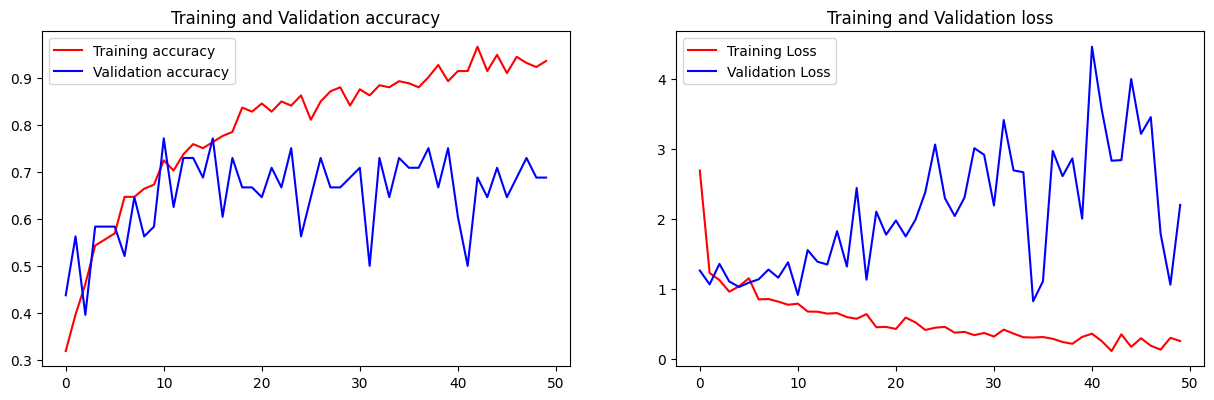

              precision    recall  f1-score   support

     Healthy       0.68      0.79      0.73        19
      Mildew       1.00      0.39      0.56        18
MinNutrition       0.72      0.68      0.70        19
         Rot       0.67      1.00      0.80        18

    accuracy                           0.72        74
   macro avg       0.77      0.72      0.70        74
weighted avg       0.77      0.72      0.70        74



In [ ]:
learning_curve(hist_6)
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_6, test_ds)

print(report_cf_matrix)

In [ ]:
#@title Skenario 3
model_622_rms = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes_622, activation='softmax')
])

model_622_rms.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])


# Pelatihan model
hist_622_rms = model_622_rms.fit(
    train_ds_622,
    steps_per_epoch=step_per_epoch_622,
    epochs=epochs_,
    validation_data=val_ds_622,
    validation_steps=val_step_622,
    verbose=1,
    )

Epoch 1/50
29/29 [==============================] - 8s 192ms/step - loss: 1.4253 - accuracy: 0.2888 - val_loss: 1.3333 - val_accuracy: 0.3125
Epoch 2/50
29/29 [==============================] - 5s 174ms/step - loss: 1.2090 - accuracy: 0.4526 - val_loss: 1.1907 - val_accuracy: 0.4792
Epoch 3/50
29/29 [==============================] - 6s 210ms/step - loss: 1.1021 - accuracy: 0.4181 - val_loss: 1.1144 - val_accuracy: 0.5000
Epoch 4/50
29/29 [==============================] - 6s 203ms/step - loss: 1.0389 - accuracy: 0.4655 - val_loss: 1.0731 - val_accuracy: 0.5000
Epoch 5/50
29/29 [==============================] - 5s 176ms/step - loss: 1.0223 - accuracy: 0.4914 - val_loss: 1.0650 - val_accuracy: 0.5208
Epoch 6/50
29/29 [==============================] - 5s 170ms/step - loss: 0.9542 - accuracy: 0.5819 - val_loss: 1.0978 - val_accuracy: 0.5000
Epoch 7/50
29/29 [==============================] - 6s 194ms/step - loss: 0.9187 - accuracy: 0.5733 - val_loss: 1.0791 - val_accuracy: 0.5625
Epoch 

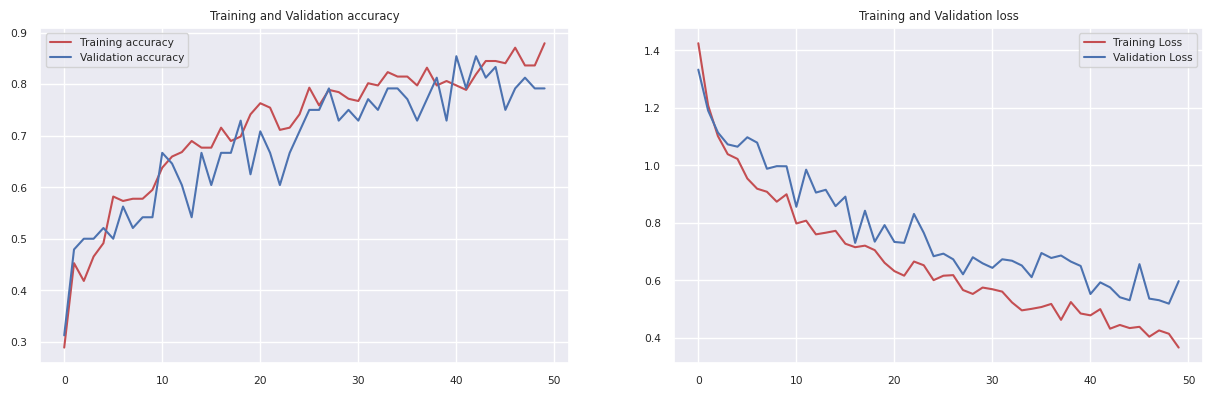

In [ ]:
#@title Hasil Kurva Pembelajaran
learning_curve(hist_622_rms)

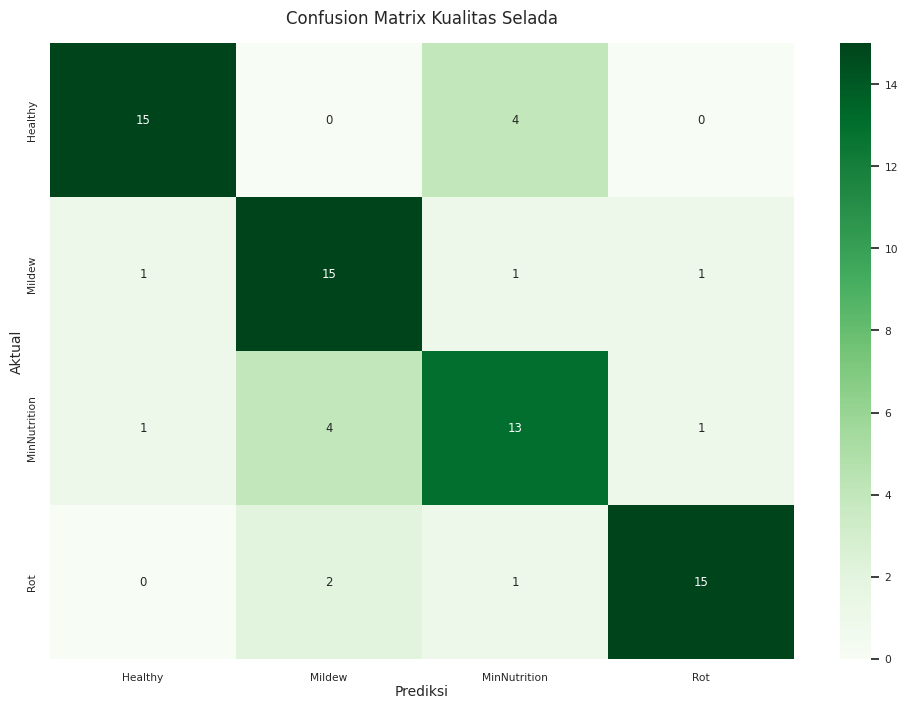

              precision    recall  f1-score   support

     Healthy       0.88      0.79      0.83        19
      Mildew       0.71      0.83      0.77        18
MinNutrition       0.68      0.68      0.68        19
         Rot       0.88      0.83      0.86        18

    accuracy                           0.78        74
   macro avg       0.79      0.79      0.79        74
weighted avg       0.79      0.78      0.79        74



In [ ]:
#@title Evaluasi Confusion Matrix
cf_matrix, report_cf_matrix = evaluation_confusion_matrix(model_622_rms, test_ds_622)

cf_matrix_heatmap(cf_matrix, classes_622)

print(report_cf_matrix)